In [1]:
%matplotlib inline
from diffusion_maps import diff_map_solver
from dataloader import *
from plotter import *
from itertools import combinations
import numpy as np
import matplotlib as mpl
from scripts import *

In [2]:
coordinates, potentials = load_dataset("../data/Lj_018f.txt", 3)
coordinates=np.array(coordinates)
coordinates = center_dataset(coordinates)

In [3]:
sample_size = 1000
coordinates = coordinates[:sample_size]
potentials = potentials[:sample_size]

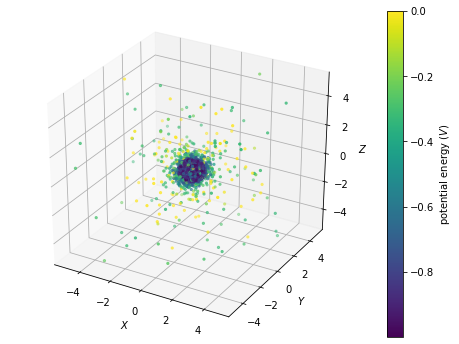

In [4]:
#collapse the dataset to 3 dimensions
X = np.reshape(coordinates, [-1, 3])
# plot the dataset in 3d space and color with potential 
fig1 = plt.figure(figsize=(8, 6))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')
a = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=np.array(potentials).repeat(3), s=5)
plt.colorbar(a, label='potential energy ($V$)')
plt.savefig("statespace_018.png")

# STEP 1: Calculate R and G 

$$
   R =
  \left[ {\begin{array}{cc}
   0 & r_{12} & r_{13} \\
   r_{21} & 0 & r_{23} \\
   r_{31} & r_{32} &0 \\
  \end{array} } \right] \\ \\
$$

Where $r_{ij}$ is distance between particle i and j and G is basically turning R into a binary array (0 and 1) based on cutoff distance.


In [5]:
# Convert coordinate space to connectivity matrices
adj = np.array([get_adjacent_matrices(config, 1.5) for config in coordinates])
R = adj[:, 0]
G = adj[:, 1]

In [6]:
R_, G_ = isorank(R, G)

In [7]:
d = isorank_dist(R, G, R_, G_)

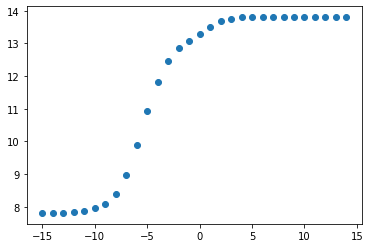

In [20]:
#selecting kernel bandwidth
def compute_A(eps):
    return np.sum( np.exp(-np.multiply(d, d) / (2.*eps)) )
# Values of epsilon in base 2 we want to scan. 
eps =np.exp(np.arange(-15.,15.,1))

# Pre-allocate array containing sum(Aij). 
Aij = np.zeros(eps.shape)

# Loop through values of epsilon and evaluate matrix sum.
for i in range(len(eps)): 
    A_ = compute_A(eps[i])
    Aij[i] = A_.sum()
plt.scatter(np.log(eps), np.log(Aij))
plt.show()

In [9]:
#calculate markov transition matrix 
sigma = np.exp(1.0)
K = np.exp(-d**2/(2.*sigma))

In [10]:
#Normalize kernel to generate markov transition matrix (M)
D = np.diag(np.sum(K, axis=1)) #sum only rows 
M = np.linalg.inv(D) @ K

In [11]:
#calculate the eigenspace 
evals, evecs = np.linalg.eig(M)

C:\Users\Aditya Dendukuri\Anaconda3\lib\site-packages\numpy\core\numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


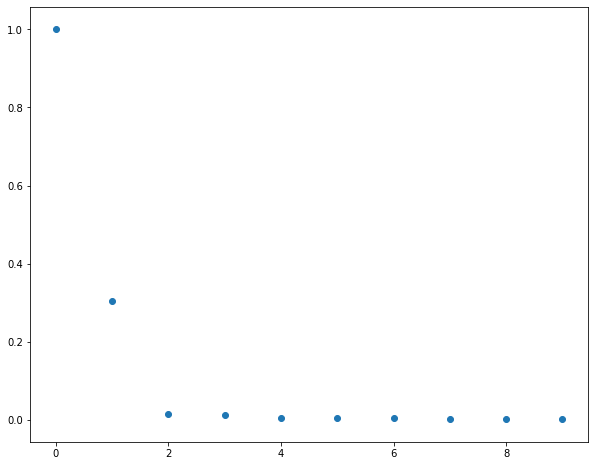

In [12]:
#plot eigenvalues
%matplotlib inline
evals_ = np.flip(np.sort(evals))[:10]
plot_2d(np.arange(0, 10, 1), evals_)

In [16]:
num_particles = len(G[0])
num_data = len(G)

#extract some information from the feature space 
side_length_space = [] #side lengths between each particles
perimeter = [] #side lengths between each particles
n_bonds = np.zeros(num_data) #number of bonds in the structure
cut_off_distance = 1.5 #sigma  
for i in range(num_data):
    side_length_space.append([])
    particles = np.reshape(coordinates[i], [num_particles, 3])
    perms = combinations(particles, 2) 
    for perm in perms:
        side_length_space[i].append(np.linalg.norm(perm[0] - perm[1]))   
    perimeter.append(np.sum(side_length_space[i]))
    for j in range(len(side_length_space[i])):
        if side_length_space[i][j] < cut_off_distance:
            n_bonds[i] += 1 

In [17]:
sample_size=1000

L_R = np.zeros(shape=R.shape)
L_G = np.zeros(shape=G.shape)
for i in range(sample_size):
    L_R[i] = np.diag(np.sum(R[i], axis=1)) - R[i]    #L_R = D_R - R
    L_G[i] = np.diag(np.sum(G[i], axis=1)) - G[i]    #L_G = D_G - G
#calculate structural variables
clusters = []
num_clusters = []
adjacency_matrices = []
spectral_radius = []
spectrum = []
vecs = []
for i, config in enumerate(coordinates[:sample_size]):
    eva, evc = np.linalg.eig(G[i])
    eva = sorted(np.abs(eva), reverse=True)
    spectral_radius.append(np.abs(eva[0] - eva[1]))
    spectrum.append(np.abs(eva))
    clusters.append(cluster_map(G[i]))
    num_clusters.append(len(clusters[len(clusters)-1]))

#connectivity values
connectivity = []
connectivity_r = []
for i in range(sample_size):
    connectivity.append(np.mean(np.sum(G[i], axis=1)))
    connectivity_r.append(np.mean(np.sum(R[i], axis=1)))

#radius of gyration
rg = np.zeros(sample_size)
for i in range(sample_size):
    rg[i] = 0.5 * (1./len(L_R[i])) * np.trace(L_R[i])

C:\Users\Aditya Dendukuri\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


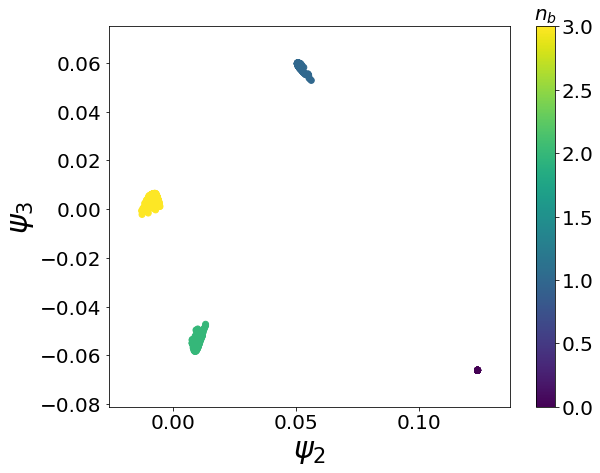

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(9, 7))
plt.xlabel("$\psi_2$", fontsize=30)
plt.ylabel("$\psi_3$", fontsize=30)
ax = fig.add_subplot(111)
plt.tick_params(labelsize=14)
a=plt.scatter(evecs[:, 1], evecs[:, 2],c= n_bonds)
cbar = plt.colorbar(a)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_title(label='$n_b$', fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.show()